In [2]:
import tensorflow as tf
from tensorflow.keras import models,layers,optimizers,losses
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import VGG16


In [3]:
base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

SET ALL THE CONSTANTS


In [4]:
BATCH_SIZE=32
IMAGE_SIZE=224
CHANNELS=3
EPOCHS=50

In [5]:
datasets=tf.keras.preprocessing.image_dataset_from_directory(
    'Images',
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    color_mode='rgb')

Found 1674 files belonging to 3 classes.


In [6]:

for image,image_labels in datasets.take(1):
    print(np.array(image).astype("uint8"))
    print(image_labels.numpy())

[[[[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  ...

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]]


 [[[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  ...

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]]


 [[[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0

In [7]:
class_names=datasets.class_names
print(class_names)

['Blister_Blide', 'Brown_Blight', 'healthy']


Visualize some of Images

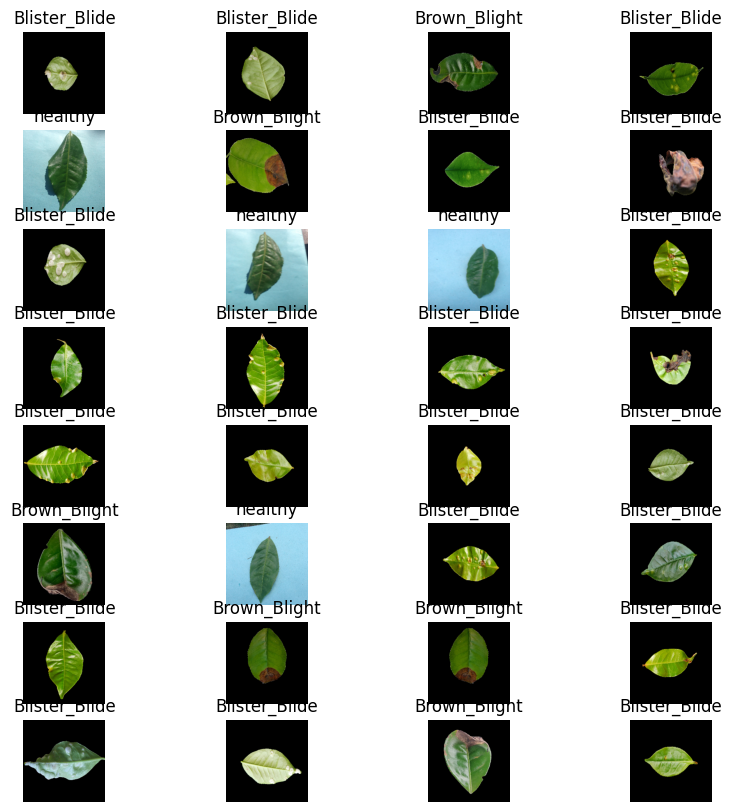

In [ ]:
plt.figure(figsize=(20,20))

for image,image_labels in datasets.take(1):
    for i in range(32):
        plt.subplot(8,4,i+1)
        plt.imshow(np.array(image[i]).astype('uint8'))
        plt.title(class_names[image_labels[i].numpy()])
        plt.axis('off')

   

Split Function

In [8]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
   
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size=int(ds_size*train_split)
    val_size=int(ds_size*val_split)

    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size+val_size)

    return train_ds,val_ds,test_ds

In [9]:
print(len(datasets))
Train_ds,Val_ds,Test_ds=get_dataset_partitions_tf(datasets)
print(len(Val_ds))

20
2


Building the Model

DATA Argumentation

In [10]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2)
])


Train_ds = Train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


In [11]:
resize_and_rescale=models.Sequential([

    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)

])

In [12]:
#Model build

input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)



model=models.Sequential([
    resize_and_rescale,
    base_model,
    
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(1,activation='sigmoid')




])
model.build(input_shape=input_shape)


In [13]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (32, 224, 224, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (32, 7, 7, 512)        │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 25088)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 1)                │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,320,449 (62.26 MB)

 Trainable params: 1,605,761 (6.13 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [14]:
model.compile(
    optimizer='adam',
    loss=losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [15]:
history=model.fit(
    Train_ds,
    batch_size=BATCH_SIZE,
    epochs=100,
    validation_data=Val_ds,


    
    
)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 69s 4s/step - accuracy: 0.5790 - loss: 1.7849 - val_accuracy: 0.7031 - val_loss: 0.4873
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 95s 6s/step - accuracy: 0.6924 - loss: 0.7393 - val_accuracy: 0.7969 - val_loss: 0.3984
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 85s 5s/step - accuracy: 0.7969 - loss: 0.4762 - val_accuracy: 0.8125 - val_loss: 0.4687
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 112s 7s/step - accuracy: 0.7994 - loss: 0.4114 - val_accuracy: 0.8906 - val_loss: 0.2700
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 123s 8s/step - accuracy: 0.8404 - loss: 0.3173 - val_accuracy: 0.8125 - val_loss: 0.4899
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 94s 6s/step - accuracy: 0.8413 - loss: 0.3989 - val_accuracy: 0.9219 - val_loss: 0.2584
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 121s 8s/step - accuracy: 0.8489 - loss: 0.3879 - val_accuracy: 0.9219 - val_loss: 0.2280
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 98s 6s/step - accuracy: 0.8358 - loss: 0.4121 - val_accuracy: 0.9020 

In [38]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    confidence = round(100 * (np.max(predictions[0])), 2)

    if(predictions[0]>0.9 and confidence>95.00):
        predicted_class=class_names[1]
    else:
        predicted_class=class_names[0]
    
   
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


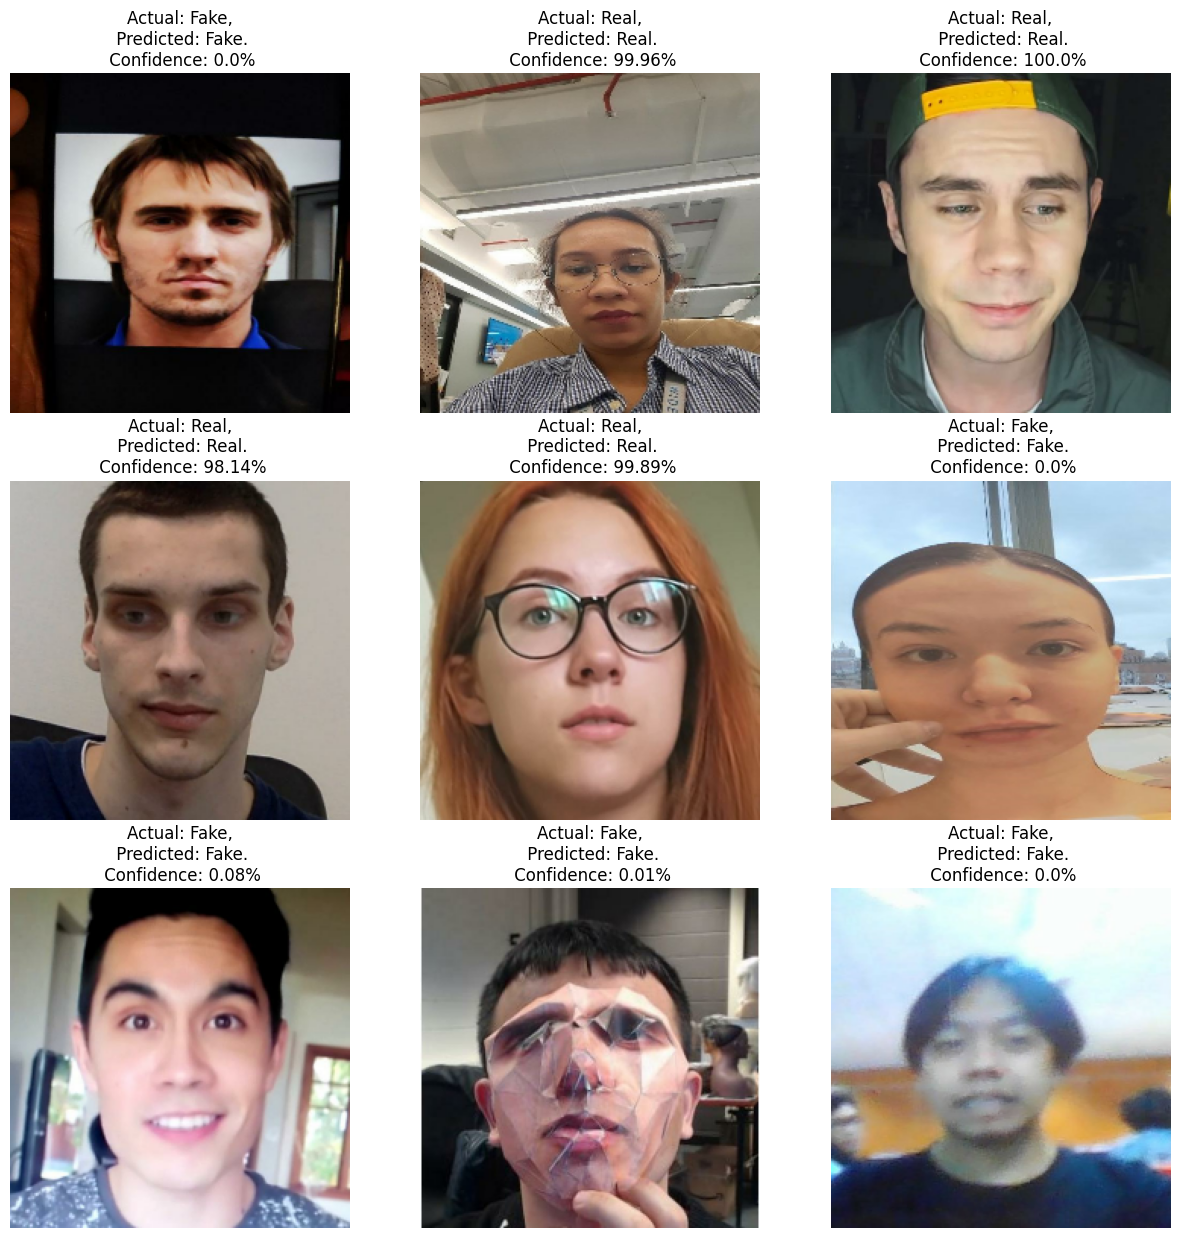

In [39]:
import numpy as np
plt.figure(figsize=(15, 15))
for images, labels in Test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [21]:
model_version=1
model.save(f'./Model/{model_version}.h5')